In [67]:
pip install tpot

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

#Model
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor

#AutoML TPot
from tpot import TPOTRegressor

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,KFold

import warnings
warnings.filterwarnings("ignore")  #--to ignore warnings

In [69]:
file_path = '/content/energy_production.csv'

df = pd.read_csv(file_path, sep=';')

In [70]:
df.head()

,temperature,exhaust_vacuum,amb_pressure,r_humidity,energy_production
0,9.59,38.56,1017.01,60.10,481.30
1,12.04,42.34,1019.72,94.67,465.36
2,13.87,45.08,1024.42,81.69,465.48
3,13.72,54.30,1017.89,79.08,467.05
4,15.14,49.64,1023.78,75.00,463.58


## EDA

In [71]:
#Checking for Null values
df.isnull().sum()

temperature          0
exhaust_vacuum       0
amb_pressure         0
r_humidity           0
energy_production    0
dtype: int64

INFERENCE :There are no NULL Values in the dataset

In [72]:
#Shape of Dataset
df.shape

(9568, 5)

In [73]:
#Data types of variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature        9568 non-null   float64
 1   exhaust_vacuum     9568 non-null   float64
 2   amb_pressure       9568 non-null   float64
 3   r_humidity         9568 non-null   float64
 4   energy_production  9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


### Checking for Outliers in the dataset

Text(0.5, 1.0, 'R Humidity')

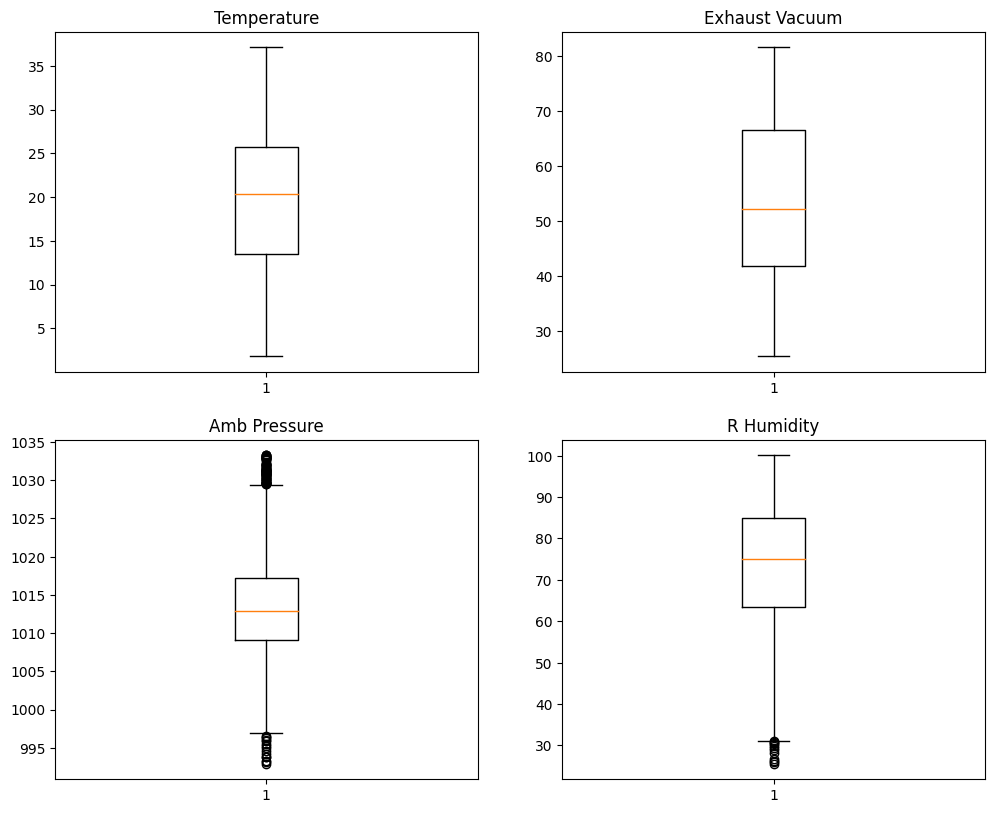

In [74]:
plt.figure(figsize=(12,15))
plt.subplot(321)
plt.boxplot(df['temperature'])
plt.title("Temperature")

plt.subplot(322)
plt.boxplot(df['exhaust_vacuum'])
plt.title("Exhaust Vacuum")

plt.subplot(323)
plt.boxplot(df['amb_pressure'])
plt.title("Amb Pressure")

plt.subplot(324)
plt.boxplot(df['r_humidity'])
plt.title("R Humidity")

In [75]:
#Descriptive Stats
df.describe()

,temperature,exhaust_vacuum,amb_pressure,r_humidity,energy_production
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In [76]:
# Calculating IQR
IQR_amb = 1017.26 - 1009.10
IQR_r = 84.83 - 63.335
#printing
print("IQR for amb_pressure is: ",IQR_amb)
print("IQR for r_humidity is: ",IQR_r)

#Calculating Lower & Upper Extreme for amb_pressure
LE_amb = 1009.10 - IQR_amb * 1.5
UE_amb = 1017.26 + IQR_amb * 1.5
#printing
print("Lower Extreme of amb_pressure is: ",LE_amb)
print("Upper Extreme of amb_pressure is: ",UE_amb)

#Calculating Lower & Upper Extreme for r_humidity
LE_r = 63.335 - IQR_r * 1.5
UE_r = 81.56 + IQR_r * 1.5
#printing
print("Lower Extreme of r_humidity is: ",LE_r)
print("Upper Extreme of r_humidity is: ",UE_r)

IQR for amb_pressure is:  8.159999999999968
IQR for r_humidity is:  21.494999999999997
Lower Extreme of amb_pressure is:  996.8600000000001
Upper Extreme of amb_pressure is:  1029.5
Lower Extreme of r_humidity is:  31.09250000000001
Upper Extreme of r_humidity is:  113.8025


#### Outliers Removal using lower and upper extreme values

In [77]:
# Original shape before outlier removal
df.shape

(9568, 5)

In [78]:
# Checking Total Outliers for Lower Extreme of amb_pressure
len(df[df.amb_pressure<LE_amb])

15

In [79]:
#Removing Outliers of amb_pressure
df1 = df[~(df.amb_pressure<LE_amb)]
df1.shape

(9553, 5)

In [80]:
# Checking Total Outliers for Upper Extreme of amb_pressure
len(df1[df1.amb_pressure>UE_amb])

73

In [81]:
#Removing Outliers of amb_pressure
df2 = df1[~(df1.amb_pressure>UE_amb)]
df2.shape

(9480, 5)

In [82]:
# Checking Total Outliers for Lower Extreme of r_humidity
len(df2[df2.r_humidity<LE_r])

12

In [83]:
# Removing Outliers of r_humidity
df3 = df2[~(df2.r_humidity<LE_r)]
df3.shape

(9468, 5)

Text(0.5, 1.0, 'R Humidity')

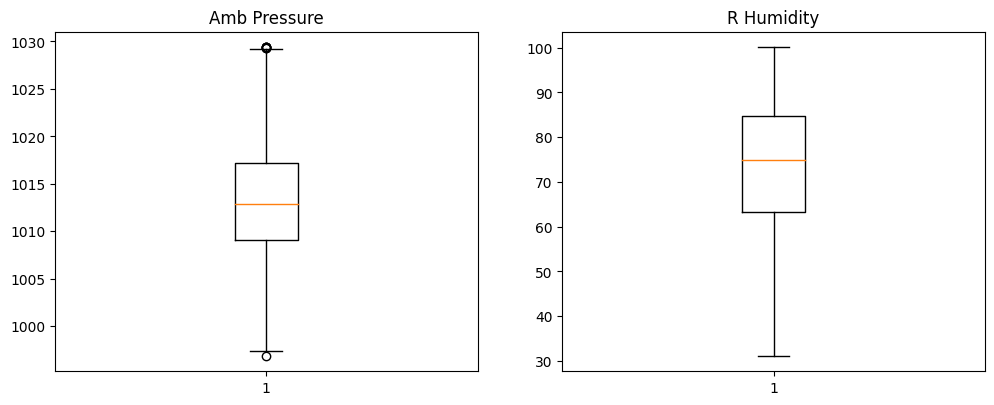

In [84]:
# BoxPlot After Outliers Removal
plt.figure(figsize=(12,15))

plt.subplot(321)
plt.boxplot(df3['amb_pressure'])
plt.title("Amb Pressure")

plt.subplot(322)
plt.boxplot(df3['r_humidity'])
plt.title("R Humidity")

**Inference: Now we only have outliers in amb_pressure,we will remove them again using IQR**

In [85]:
# Descriptive Stats
df3.describe()

,temperature,exhaust_vacuum,amb_pressure,r_humidity,energy_production
count,9468.000000,9468.00000,9468.000000,9468.000000,9468.000000
mean,19.719883,54.41369,1013.148802,73.322083,454.209298
std,7.427311,12.70141,5.704623,14.551203,17.029285
min,1.810000,25.36000,996.870000,31.150000,420.260000
25%,13.577500,41.74000,1009.090000,63.285000,439.697500
50%,20.500000,52.72000,1012.900000,74.980000,451.210000
75%,25.760000,66.54000,1017.170000,84.840000,468.190000
max,37.110000,81.56000,1029.410000,100.160000,495.760000


In [86]:
# Calculating IQR
IQR = 1017.17 - 1009.09
#printing
print("IQR for amb_pressure is: ",IQR)

#Calculating Lower & Upper Extreme for amb_pressure
LE = 1009.09 - IQR * 1.5
UE = 1017.17 + IQR * 1.5
#printing
print("Lower Extreme of amb_pressure is: ",LE)
print("Upper Extreme of amb_pressure is: ",UE)

IQR for amb_pressure is:  8.079999999999927
Lower Extreme of amb_pressure is:  996.9700000000001
Upper Extreme of amb_pressure is:  1029.29


In [87]:
# Checking Total Outliers for Lower Extreme of amb_pressure
len(df3[df3.amb_pressure<LE])

1

In [88]:
#Removing Outliers of amb_pressure
df4 = df3[~(df3.amb_pressure<LE)]
df4.shape

(9467, 5)

In [89]:
# Checking Total Outliers for Upper Extreme of amb_pressure
len(df4[df4.amb_pressure>UE])

6

In [90]:
#Removing Outliers of amb_pressure
df5 = df4[~(df4.amb_pressure>UE)]
df5.shape

(9461, 5)

Text(0.5, 1.0, 'Amb Pressure')

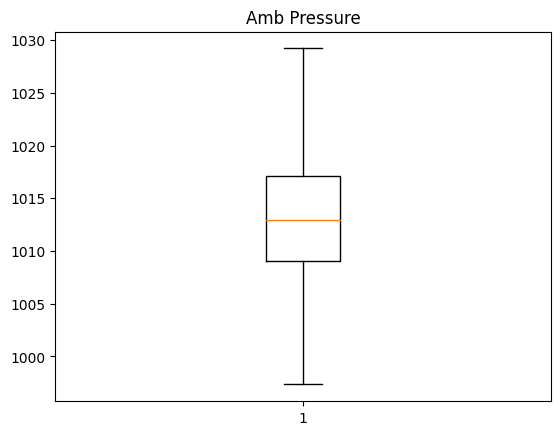

In [91]:
#BoxPlot After Outliers Removal
plt.boxplot(df5['amb_pressure'])
plt.title("Amb Pressure")

**Inference : There are No more Outliers present in the dataset**

In [92]:
# Final Dataset after EDA
df5.head()

,temperature,exhaust_vacuum,amb_pressure,r_humidity,energy_production
0,9.59,38.56,1017.01,60.10,481.30
1,12.04,42.34,1019.72,94.67,465.36
2,13.87,45.08,1024.42,81.69,465.48
3,13.72,54.30,1017.89,79.08,467.05
4,15.14,49.64,1023.78,75.00,463.58


### Histogram Plot

Text(0.5, 1.0, 'R Humidity')

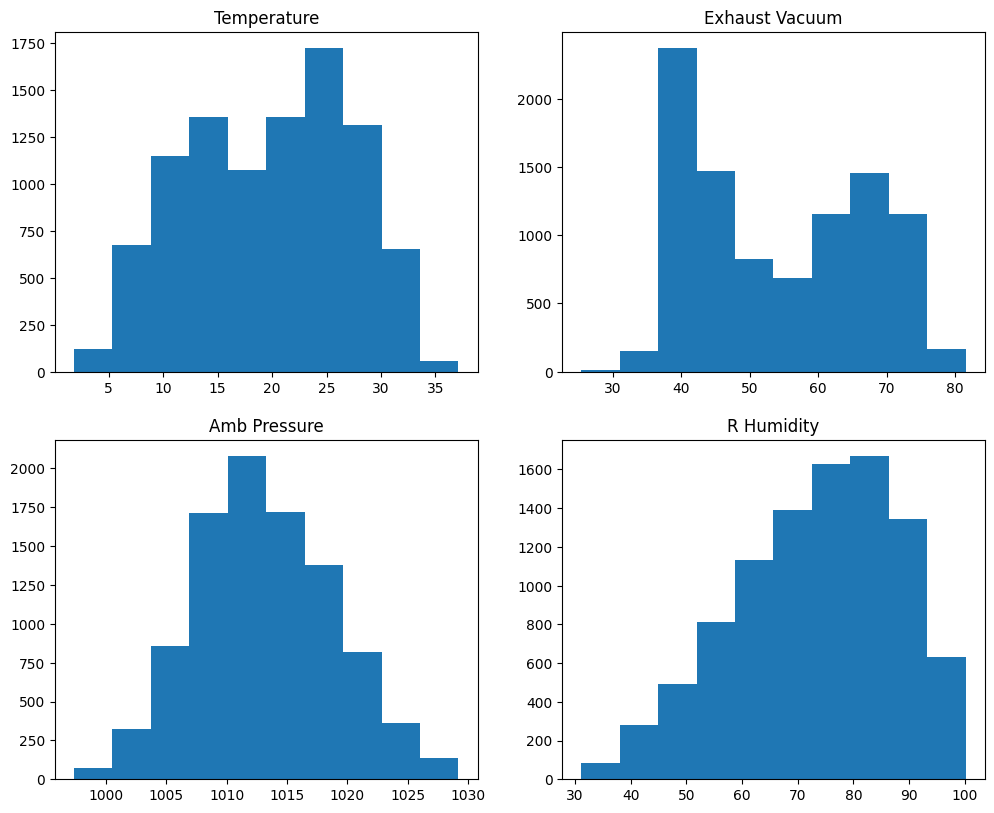

In [93]:
plt.figure(figsize=(12,15))
plt.subplot(321)
plt.hist(df5['temperature'])
plt.title("Temperature")

plt.subplot(322)
plt.hist(df5['exhaust_vacuum'])
plt.title("Exhaust Vacuum")

plt.subplot(323)
plt.hist(df5['amb_pressure'])
plt.title("Amb Pressure")

plt.subplot(324)
plt.hist(df5['r_humidity'])
plt.title("R Humidity")

### Detecting Collieanrity B/W Independent Variables

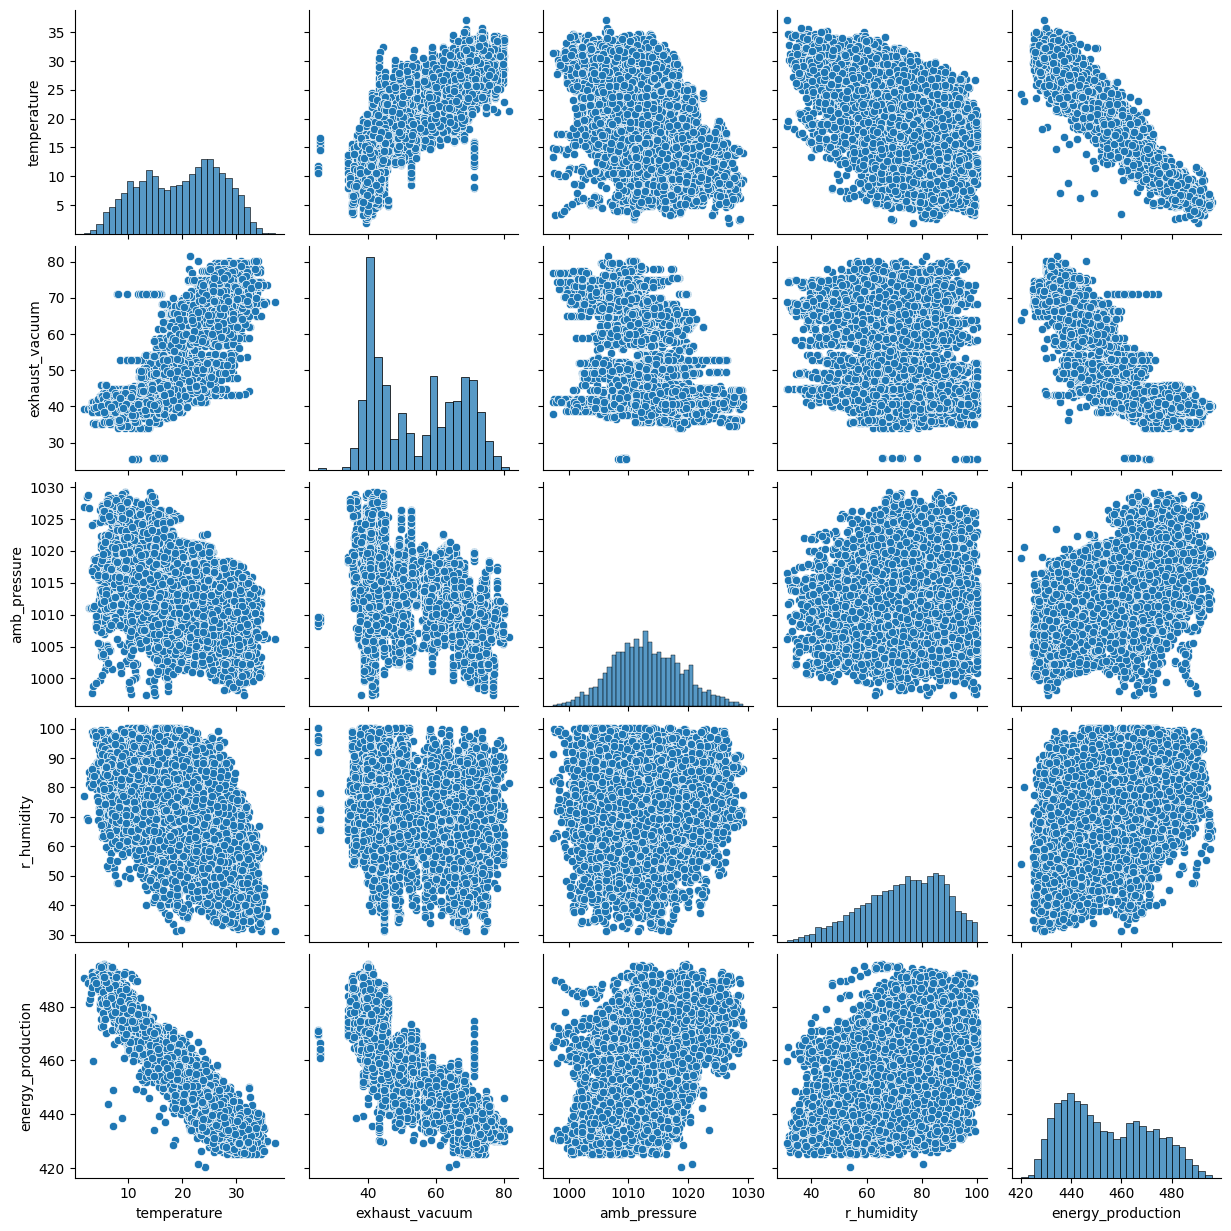

In [94]:
sns.pairplot(df5)

In [95]:
df5.corr()

,temperature,exhaust_vacuum,amb_pressure,r_humidity,energy_production
temperature,1.000000,0.842728,-0.508625,-0.542175,-0.947491
exhaust_vacuum,0.842728,1.000000,-0.415389,-0.310217,-0.868693
amb_pressure,-0.508625,-0.415389,1.000000,0.105210,0.521194
r_humidity,-0.542175,-0.310217,0.105210,1.000000,0.388023
energy_production,-0.947491,-0.868693,0.521194,0.388023,1.000000


**Inference: As we can see "temperature" & "exhaust_vaccum" have a strong positve Correlation, So can say there is a multicollinearity effect present**

### Cross-check with VIF

In [96]:
rsq_Tem = smf.ols('temperature~exhaust_vacuum+amb_pressure+r_humidity',data=df5).fit().rsquared
vif_Tem = 1/(1-rsq_Tem)

rsq_ex = smf.ols('exhaust_vacuum~temperature+amb_pressure+r_humidity',data=df5).fit().rsquared
vif_ex = 1/(1-rsq_ex)

rsq_amb = smf.ols('amb_pressure~temperature+exhaust_vacuum+r_humidity',data=df5).fit().rsquared
vif_amb = 1/(1-rsq_amb)

rsq_rh = smf.ols('r_humidity~temperature+exhaust_vacuum+amb_pressure',data=df5).fit().rsquared
vif_rh = 1/(1-rsq_rh)

# Storing vif values in a data frame
d1 = {'Variables':['temperature','exhaust_vacuum','amb_pressure','r_humidity'],'VIF':[vif_Tem,vif_ex,vif_amb,vif_rh]}
Vif_frame = pd.DataFrame(d1)
Vif_frame

,Variables,VIF
0,temperature,5.906452
1,exhaust_vacuum,3.907032
2,amb_pressure,1.447254
3,r_humidity,1.696703


**Inference: There is no Mulit-collinearity between the variables , Since VIF is less then 20.**

### Overview  Report of EDA

In [97]:
pip install pandas_profiling

In [98]:
import pandas_profiling as pp

In [99]:
EDA_report= pp.ProfileReport(df5)
EDA_report.to_file(output_file='report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [100]:
df5

,temperature,exhaust_vacuum,amb_pressure,r_humidity,energy_production
0,9.59,38.56,1017.01,60.10,481.30
1,12.04,42.34,1019.72,94.67,465.36
2,13.87,45.08,1024.42,81.69,465.48
3,13.72,54.30,1017.89,79.08,467.05
4,15.14,49.64,1023.78,75.00,463.58
...,...,...,...,...,...
9563,17.10,49.69,1005.53,81.82,457.32
9564,24.73,65.34,1015.42,52.80,446.92
9565,30.44,56.24,1005.19,56.24,429.34
9566,23.00,66.05,1020.61,80.29,421.57


## MODEL BUILDING

In [101]:
#Splitting X & Y Variable
X = df5.iloc[:,0:4]
Y = df5.iloc[:,4]

In [102]:
X.head()

,temperature,exhaust_vacuum,amb_pressure,r_humidity
0,9.59,38.56,1017.01,60.10
1,12.04,42.34,1019.72,94.67
2,13.87,45.08,1024.42,81.69
3,13.72,54.30,1017.89,79.08
4,15.14,49.64,1023.78,75.00


In [103]:
Y.head()

0    481.30
1    465.36
2    465.48
3    467.05
4    463.58
Name: energy_production, dtype: float64

In [104]:
# Train & Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=10)

### Linear Model

In [105]:
#Model
Lmodel = LinearRegression()
Lmodel.fit(X_train,Y_train)
Lmodel.score(X_test,Y_test)*100

93.06433601411435

### Model Validation

In [106]:
#Kfold of Linear model
kfold = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), X, Y, cv=kfold)

array([0.93055762, 0.92618122, 0.93250536, 0.92817959, 0.92822301])

### Lasso and Ridge Regression

In [107]:
# Apply multiple Linear Regression Model
lreg = LinearRegression()
lreg.fit(X_train, Y_train)

# Generate Prediction on test set
lreg_y_pred = lreg.predict(X_test)

# calculating Mean Squared Error (mse)
mean_squared_error = np.mean((lreg_y_pred - Y_test)**2)
print("Mean squared Error on test set : ", mean_squared_error)

# Putting together the coefficient and their corrsponding variable names
lreg_coefficient = pd.DataFrame()
lreg_coefficient["Columns"] = X_train.columns
lreg_coefficient['Coefficient Estimate'] = pd.Series(lreg.coef_)
print(lreg_coefficient)

Mean squared Error on test set :  21.014531464302415
          Columns  Coefficient Estimate
0     temperature             -1.976978
1  exhaust_vacuum             -0.230651
2    amb_pressure              0.080290
3      r_humidity             -0.160460


<Axes: xlabel='Coefficient Estimate', ylabel='Columns'>

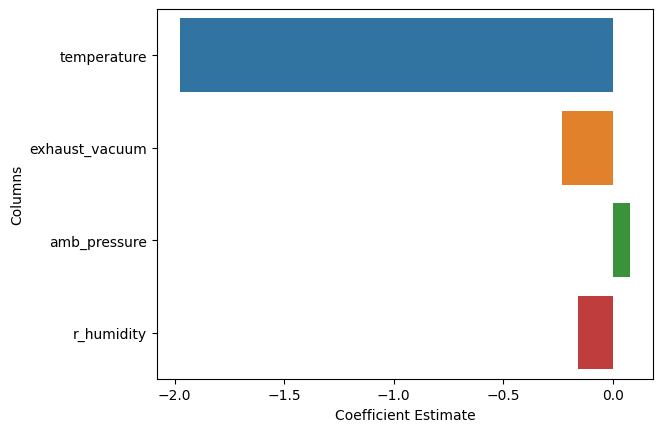

In [108]:
sns.barplot(x='Coefficient Estimate' , y='Columns', data=lreg_coefficient)

In [109]:
# Ridge regression
from sklearn.linear_model import Ridge

# Train the model
ridgeR = Ridge(alpha = 1)
ridgeR.fit(X_train, Y_train)
y_pred = ridgeR.predict(X_test)

# calculate mean square error
mean_squared_error_ridge = np.mean((y_pred - Y_test)**2)
print("Mean_Squared_error:",mean_squared_error_ridge)

# get ridge coefficient and print them
ridge_coefficient = pd.DataFrame()
ridge_coefficient["Columns"]= X_train.columns
ridge_coefficient['Coefficient Estimate'] = pd.Series(ridgeR.coef_)
print(ridge_coefficient)

Mean_Squared_error: 21.01452500349596
          Columns  Coefficient Estimate
0     temperature             -1.976951
1  exhaust_vacuum             -0.230662
2    amb_pressure              0.080297
3      r_humidity             -0.160455


In [110]:
# Lasso Regression
from sklearn.linear_model import Lasso

# Train the model
lasso = Lasso(alpha = 1)
lasso.fit(X_train, Y_train)
y_pred1 = lasso.predict(X_test)

# Calculate Mean Squared Error
mean_squared_error = np.mean((y_pred1 - Y_test)**2)
print("Mean squared error on test set", mean_squared_error)
lasso_coeff = pd.DataFrame()
lasso_coeff["Columns"] = X_train.columns
lasso_coeff['Coefficient Estimate'] = pd.Series(lasso.coef_)

print(lasso_coeff)

Mean squared error on test set 21.021888475894894
          Columns  Coefficient Estimate
0     temperature             -1.921902
1  exhaust_vacuum             -0.248816
2    amb_pressure              0.064529
3      r_humidity             -0.144717


## Ensemble Techniques

In [111]:
# Decision Tree Regressor
seed = 7
kfold = KFold(n_splits=10, random_state=seed,shuffle=True)
cart = DecisionTreeRegressor()
num_trees = 100
model = BaggingRegressor(base_estimator=cart, n_estimators=num_trees, random_state=seed)
results = cross_val_score(model, X_train, Y_train, cv=kfold)
print(results.mean())

0.9599131469522387


In [112]:
# Random Forest Regressor
num_trees = 100
max_features = 3
kfold = KFold(n_splits=10, random_state=7,shuffle=True)
model = RandomForestRegressor(n_estimators=num_trees, max_features=max_features)
results = cross_val_score(model, X_train, Y_train, cv=kfold)
print(results.mean())

0.9608584961310465


In [113]:
# Adaboost Regressor
num_trees = 10
seed=7
kfold = KFold(n_splits=10, random_state=seed,shuffle=True)
model = AdaBoostRegressor(n_estimators=num_trees, random_state=seed)
results = cross_val_score(model, X_train, Y_train, cv=kfold)
print(results.mean())

0.9075739194628539


## KNN Model

In [114]:
n_neighbors = np.array(range(1,41))
param_grid = dict(n_neighbors=n_neighbors)
model = KNeighborsRegressor()
grid = GridSearchCV(estimator=model,param_grid=param_grid)
grid.fit(X_train,Y_train)
print(grid.best_score_)
print(grid.best_params_)

0.9436345358354734
{'n_neighbors': 5}


In [115]:
KNN_model = KNeighborsRegressor(n_neighbors=5)
KNN_model.fit(X_train,Y_train)

KNeighborsRegressor()

In [116]:
Y_pred = KNN_model.predict(X_test)
KNN_1 = metrics.explained_variance_score(Y_test,Y_pred)
print("Accuracy:" ,KNN_1)

Accuracy: 0.9443999431784652


### Choosing the best Model

In [117]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [119]:
import pandas as pd
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

def find_best_model_using_gridsearchcv(x, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {}
        },
        'ridge': {
            'model': Ridge(),
            'params': {'alpha': [0.1, 0.5, 1]}
        },
        'lasso': {
            'model': Lasso(),
            'params': {'alpha': [0.1, 0.5, 1], 'selection': ['random', 'cyclic']}
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {'criterion': ['mse', 'friedman_mse'], 'splitter': ['best', 'random']}
        },
        'random_forest': {
            'model': RandomForestRegressor(),
            'params': {'n_estimators': [100, 125, 150, 200], 'max_features': [3, 4]}
        },
        'xgboost': {
            'model': XGBRegressor(),
            'params': {'n_estimators': [100, 125, 150, 200, 225, 250], 'max_depth': [3, 4, 5], 'learning_rate': [0.1, 0.2]}
        },
        'svm': {
            'model': SVR(),
            'params': {'kernel': ['rbf']}
        },
        'knn': {
            'model': KNeighborsRegressor(),
            'params': {'n_neighbors': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]}
        }
    }

    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)

    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv)
        gs.fit(x, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

# Assuming you have your data X and labels Y
result_df = find_best_model_using_gridsearchcv(X, Y)
print(result_df)


               model  best_score  \
0  linear_regression    0.929326   
1              ridge    0.929326   
2              lasso    0.929328   
3      decision_tree    0.925954   
4      random_forest    0.963071   
5            xgboost    0.966585   
6                svm    0.376926   
7                knn    0.945204   

                                         best_params  
0                                                 {}  
1                                       {'alpha': 1}  
2              {'alpha': 0.1, 'selection': 'cyclic'}  
3  {'criterion': 'friedman_mse', 'splitter': 'best'}  
4           {'max_features': 3, 'n_estimators': 200}  
5  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...  
6                                  {'kernel': 'rbf'}  
7                                 {'n_neighbors': 5}  


### Best Model For Deployment

**XGBoost**

In [120]:
gb_model = XGBRegressor(n_estimators=250,learning_rate=0.2, max_depth=5)
gb_model.fit(X_train,Y_train)
gb_model.score(X_test,Y_test)*100

96.75663719774154

In [121]:
import pickle

In [122]:
pickle_out = open('gb_model.pkl','wb')
pickle.dump(gb_model,pickle_out)
pickle_out.close()

**Random Forest**

In [123]:
rf_model = RandomForestRegressor(n_estimators=10, random_state=20)
rf_model.fit(X_train,Y_train)
rf_model.score(X_test,Y_test)*100

95.93349411371767

**Pickling the File**

In [124]:
pickle_out = open('rf_model.pkl','wb')
pickle.dump(rf_model,pickle_out)
pickle_out.close()